In [4]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf


(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

maxlen = 200
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)

In [5]:
from tensorflow.keras import layers, models

class TokenAndPosisionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPosisionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training = True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [9]:
embed_dim = 32
num_heads = 2
ff_dim = 32

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPosisionEmbedding(maxlen, 20000, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = models.Model(inputs=inputs, outputs=outputs)

In [10]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)



Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 66ms/step - accuracy: 0.6625 - loss: 0.5739 - val_accuracy: 0.8700 - val_loss: 0.2984
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.9242 - loss: 0.2058 - val_accuracy: 0.8716 - val_loss: 0.3295
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.9641 - loss: 0.1084 - val_accuracy: 0.8720 - val_loss: 0.3916
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.9792 - loss: 0.0679 - val_accuracy: 0.8584 - val_loss: 0.4896
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9889 - loss: 0.0367 - val_accuracy: 0.8646 - val_loss: 0.5426


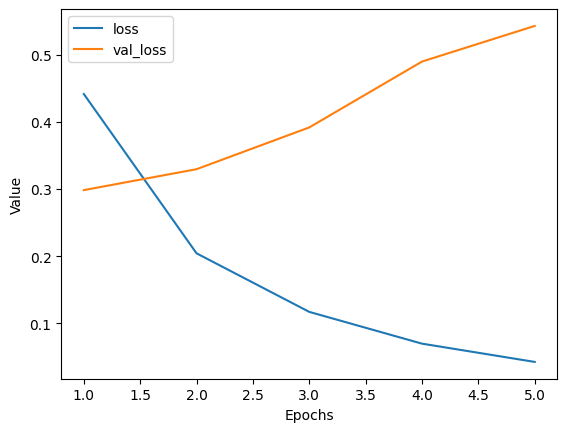

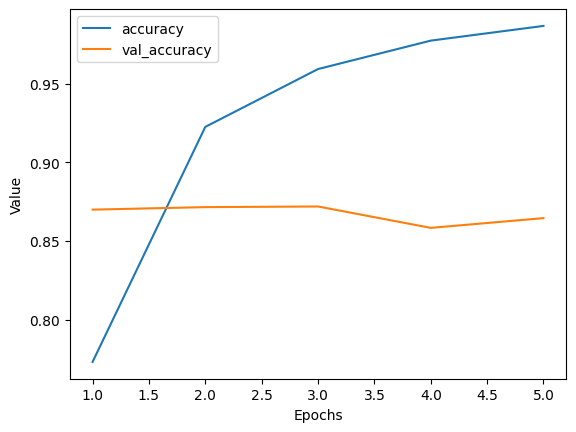

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()


plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='loss')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='accuracy')
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()